In [1]:
chat = ''
# Enter the path where the chat is stored
file_name = './chat1.txt'
with open(file_name, mode = 'r', encoding = 'utf-8') as f:
    chat = f.readlines()

In [2]:
senders = set()      # To mark whether a message traversed is from a new sender or old
messages = dict()    # Store all messages in structured format
dates = dict()       # Store all dates in structures format
last = None

for msg in chat:
    if not (len(msg) > 12 and msg[2] == '/' and msg[5] == '/' and msg[8] == ',' and (msg[11] == ':' or msg[12] == ':')):
        # This means there was a newline in chat and is a part of previous message
        messages[last][-1] += ' ' + content
        continue
            
    # Extract different components of raw data
    try:
        d, t = msg.index(','), msg.index('-')
        s = t + msg[t:].index(':')
        date = msg[:d]
        tim = msg[d+2:t]
        sender = msg[t+2:s]
        content = msg[s+2:-1]
    except:
        # Irrevelant stuff such as changed group's icon, left group, joined group, etc.
        continue
        
    # Adding data
    if sender not in senders:
        senders.add(sender)
        messages[sender] = [content]
        dates[sender] = dict()
    else:
        messages[sender].append(content)
            
    if date in dates[sender]:
        dates[sender][date] += 1
    else:
        dates[sender][date] = 1
            
    last = sender

In [3]:
def sort_dates(dates):
    dates.sort(key = lambda date: list(map(int, date.split('/')))[::-1])
    return dates

In [4]:
def get_date_difference(date1, date2):
    from datetime import date
    d1, m1, y1 = map(int, date1.split('/'))
    d2, m2, y2 = map(int, date2.split('/'))
    diff = date(y2, m2, d2) - date(y1, m1, d1)
    return abs(diff.days)

In [5]:
def convert_date(date):
    # Convert date from dd/mm/yy format to day-mon-YY format
    day, month, year = map(int, date.split('/'))
    res = ''
    res += str(day)
    if day in [1,21,31]:
        res += 'st '
    elif day in [2, 22]:
        res += 'nd '
    elif day in [3, 23]:
        res += 'rd '
    else:
        res += 'th '
    months = ['', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    res += months[month]
    res += " 20" + str(year)    
    return res

In [6]:
# Date statistics

def biggest_date_difference(dates):       # Input: list[key list of dates dictionary]
    dates = sort_dates(dates)
    if len(dates) == 1:
        return 0
    max_diff = get_date_difference(dates[0], dates[1])
    date1 = dates[0]
    date2 = dates[1]
    for i in range(1, len(dates)):
        diff = get_date_difference(dates[i-1], dates[i])
        if diff > max_diff:
            max_diff = diff
            date1 = dates[i-1]
            date2 = dates[i]
    
    return max_diff, date1, date2

def longest_streak(dates):                # Input: list[key list of dates dictionary]
    dates = sort_dates(dates)
    streak = 1
    max_streak = 1
    st, max_st = dates[0], dates[0]
    en, max_en = dates[0], dates[0]
    for i in range(1,len(dates)):
        if get_date_difference(dates[i], dates[i-1]) == 1:
            streak += 1
            en = dates[i]
        else:
            if streak > max_streak:
                max_streak = streak
                max_st = st
                max_en = en
            streak = 1
            st = dates[i]
    if streak > max_streak:
        max_streak = streak
        max_st = st
        max_en = en
    return max_streak, max_st, max_en

def most_messages_per_day(dates):              # Input: dictionary[dates dictionary]
    top3 = [[None, 0], [None, 0], [None, 0]]       # [0]: 3rd rank, [1]: 2nd rank [2]: 3rd rank
    for i in dates:
        if top3[0][1] < dates[i]:
            top3[0][0] = i
            top3[0][1] = dates[i]
        top3.sort(key = lambda x: x[1])
    return top3

In [7]:
# Message Counts

def sender_count(sender_msg):
    return len(sender_msg)

In [8]:
# Creating Dashboard
stat_sender = dict()
total_msgs = 0
for sender in senders:
    stat_sender[sender] = dict()
    
    date_diff, st, en = biggest_date_difference(list(dates[sender].keys()))
    stat_sender[sender]['biggest_date_difference'] = (date_diff, convert_date(st), convert_date(en))
    
    streak, st, en = longest_streak(list(dates[sender].keys()))
    stat_sender[sender]['longest_streak'] = (streak, convert_date(st), convert_date(en))
    
    top3 = most_messages_per_day(dates[sender])[::-1]
    for i in range(len(top3)):
        top3[i][0] = convert_date(top3[i][0])
    stat_sender[sender]['most_messages'] = top3
    
    count = sender_count(messages[sender])
    stat_sender[sender]['total_messages'] = count
    total_msgs += count

In [9]:
# Content Statistics
for sender in senders:
    count = 0
    for m in messages[sender]:
        if "<Media omitted>" in m:
            count += 1
    stat_sender[sender]["media"] = count

In [10]:
# Group Statistics

participants = []
for sender in senders:
    participants.append([sender, stat_sender[sender]['total_messages']])
participants.sort(key = lambda x: -x[1])

date_count = dict()
for sender in senders:
    for date in dates[sender]:
        if date in date_count:
            date_count[date] += dates[sender][date]
        else:
            date_count[date] = dates[sender][date]
date_count = list(date_count.items())
date_count.sort(key = lambda x: -x[1])

In [11]:
from IPython.display import display, Markdown as md

display(md("## User Statistics"))
for ctr, sender in enumerate(senders,1):
    display(md("#### {}. {}".format(ctr, sender)))
    display(md("* Total Messages: {}".format(stat_sender[sender]['total_messages'])))
    display(md("* Media Sent: {}".format(stat_sender[sender]['media'])))
    display(md("* Top most active days:-"))
    for day, count in stat_sender[sender]['most_messages']:
        display(md("{}> {}: {} messages".format(' '*10,day, count)))
    c, s, e = stat_sender[sender]['longest_streak']
    display(md("* Longest Streak: {} days (from {} to {})".format(c,s,e)))
    c, s, e = stat_sender[sender]['biggest_date_difference']
    display(md("* Longest Span without messages: {} days (from {} to {})".format(c,s,e)))

## User Statistics

#### 1. Jiju

* Total Messages: 563

* Media Sent: 388

* Top most active days:-

          > 3rd May 2020: 117 messages

          > 8th March 2020: 62 messages

          > 26th February 2020: 60 messages

* Longest Streak: 11 days (from 15th March 2020 to 25th March 2020)

* Longest Span without messages: 5 days (from 10th March 2020 to 15th March 2020)

#### 2. Jijaji

* Total Messages: 354

* Media Sent: 167

* Top most active days:-

          > 27th October 2019: 14 messages

          > 14th August 2019: 13 messages

          > 26th January 2019: 12 messages

* Longest Streak: 6 days (from 17th March 2020 to 22nd March 2020)

* Longest Span without messages: 30 days (from 16th January 2020 to 15th February 2020)

#### 3. Mummy

* Total Messages: 78

* Media Sent: 36

* Top most active days:-

          > 28th August 2019: 11 messages

          > 1st January 2020: 6 messages

          > 19th August 2019: 4 messages

* Longest Streak: 3 days (from 4th February 2019 to 6th February 2019)

* Longest Span without messages: 49 days (from 6th January 2020 to 24th February 2020)

#### 4. Papaji

* Total Messages: 1078

* Media Sent: 498

* Top most active days:-

          > 30th January 2020: 76 messages

          > 26th January 2019: 48 messages

          > 25th March 2020: 30 messages

* Longest Streak: 20 days (from 13th March 2020 to 1st April 2020)

* Longest Span without messages: 6 days (from 14th March 2019 to 20th March 2019)

#### 5. Noopur Di

* Total Messages: 916

* Media Sent: 193

* Top most active days:-

          > 7th April 2020: 23 messages

          > 27th November 2018: 22 messages

          > 31st December 2019: 19 messages

* Longest Streak: 16 days (from 3rd April 2020 to 18th April 2020)

* Longest Span without messages: 11 days (from 9th August 2019 to 20th August 2019)

#### 6. Mrudul

* Total Messages: 827

* Media Sent: 178

* Top most active days:-

          > 5th July 2019: 33 messages

          > 24th March 2020: 22 messages

          > 23rd November 2018: 17 messages

* Longest Streak: 9 days (from 8th July 2019 to 16th July 2019)

* Longest Span without messages: 12 days (from 9th March 2019 to 21st March 2019)

#### 7. Namrata Di

* Total Messages: 1232

* Media Sent: 357

* Top most active days:-

          > 23rd February 2020: 59 messages

          > 9th July 2019: 29 messages

          > 17th August 2019: 19 messages

* Longest Streak: 14 days (from 2nd October 2019 to 15th October 2019)

* Longest Span without messages: 8 days (from 8th April 2019 to 16th April 2019)

In [13]:
display(md("## Overall Statistics"))
    
display(md("#### Most active participants"))
ctr = 1
for ind, (s, c) in enumerate(participants[:min(10,len(participants))], 1):
    display(md("{}. {}: {} messages ({}%)".format(ctr, s, c, int((c/total_msgs) * 100))))
    ctr += 1
    
print('\n'*2)
display(md("#### Most active days"))
for day, count in date_count[:min(5, len(date_count))]:
    display(md("> {}: {} messages".format(convert_date(day), count)))

## Overall Statistics

#### Most active participants

1. Namrata Di: 1232 messages (24%)

2. Papaji: 1078 messages (21%)

3. Noopur Di: 916 messages (18%)

4. Mrudul: 827 messages (16%)

5. Jiju: 563 messages (11%)

6. Jijaji: 354 messages (7%)

7. Mummy: 78 messages (1%)

#### Most active days

> 3rd May 2020: 121 messages

> 23rd February 2020: 119 messages

> 30th January 2020: 76 messages

> 25th March 2020: 75 messages

> 8th March 2020: 74 messages

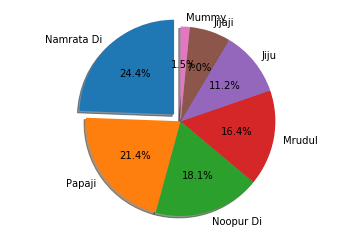

In [15]:
# Visualizations

import matplotlib.pyplot as plt
labels = []
sizes = []
for l, s in participants:
    labels.append(l)
    sizes.append(s)
explode = [0.0] * len(labels)
explode[sizes.index(max(sizes))] = 0.1
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode = explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()